# Welcome to the LIGO data visualization tutorial! 

## Installation

Please make sure you have [GWpy](https://gwpy.github.io/docs/latest/install/index.html) installed before you begin!   

In [ ]:
! python3 -m pip install gwpy

<span style="color:gray">Jess notes: the following was produced using a python3.7 kernel. All code dependencies should be installed via the installation instructions above except for python; careful with your python paths here.</span> 

### Learning goals

With this tutorial, you will learn how to: 

* Use basic [GWOSC](https://www.gw-openscience.org/about/) tools to query for LIGO-Virgo observing run times and GW event times 
* Download public LIGO (and Virgo) data from the GWOSC with GWpy 
* Plot a LIGO h(t) time series with GWpy
* Make a spectral density plot of a time series
* Design a filter in the frequency domain 
* Apply and characterize a whitening filter
* Visualize LIGO data with spectrograms 

This tutorial borrows from the excellent work of Duncan Macleod, Jonah Kanner, Alex Nitz, and others involved in the [2018 GWOSC webcourse](https://www.gw-openscience.org/static/workshop1/course.html) - you can find many more great examples there. 

<span style="color:green"> **Excercises are in green.** </span>

Let's get started! 

___

## Using GWOSC tools 

Here we'll use tools from the Gravitational Wave Open Science Center ([GWOSC](https://www.gw-openscience.org/about/)), namely the [gwosc python module](https://gwosc.readthedocs.io/en/latest/), which we should have already installed via our GWpy install. 

First, let's see what's in GWOSC open datasets: 

In [1]:
from gwosc.datasets import find_datasets
find_datasets()

['151008',
 '151012A',
 '151116',
 '161202',
 '161217',
 '170208',
 '170219',
 '170405',
 '170412',
 '170423',
 '170616',
 '170630',
 '170705',
 '170720',
 'BKGW170608_16KHZ_R1',
 'GW150914',
 'GW151012',
 'GW151226',
 'GW170104',
 'GW170608',
 'GW170729',
 'GW170809',
 'GW170814',
 'GW170817',
 'GW170818',
 'GW170823',
 'GWTC-1-confident',
 'GWTC-1-marginal',
 'O1',
 'O1_16KHZ',
 'O2_16KHZ_R1',
 'O2_4KHZ_R1',
 'S5',
 'S6']

Here we see data for: 

* **[GWTC-1](https://arxiv.org/abs/1811.12907) confident events**: GW150914, GW151012, GW151226, GW170104, GW170608, GW170729, GW170809, GW170814, GW170817, GW170818, and GW170823
* **[GWTC-1](https://arxiv.org/abs/1811.12907) marginal events**: 151008, 151012A, 151116, 161202, 161217, 170208, 170219, 170405, 170412, 170423, 170616, 170630, 170705, 170720
* **Observing runs**: Advanced LIGO and Advanced Virgo observing runs O1 and O2 at different sampling rates, as well as past science runs S5 and S6 (pre 2010). 
* And background data for an event included in the GWTC-1 catalog, but not in the O2 data release: BKGW170608_16KHZ_R1

---

#### Observing runs

Knowing this, let's try to query for the start and end of LIGO-Virgo **observing runs**. Currently, data from the first two observing runs are available via the GWOSC: O1 and O2.

`gwosc.datasets.run_segment` will return the start and end GPS times for an observing run given a dataset tag. Let's try O1:

In [2]:
from gwosc.datasets import run_segment
print(run_segment('O1'))

(1126051217, 1137254417)


And O2: 

In [3]:
print(run_segment('O2'))

ValueError: no run dataset found for 'O2'

<span style="color:green">
    
### Exercise 

**There's an error here!** Can you find a way to fix the cell above and print the start and end times for the second LIGO-Virgo observing run (O2)? 
    
</span>

___

#### Querying for data around detected events

We can also query for event releases (data on the order of minutes around the event time) specifically by using `find_datasets` and specifying the `event` type. 

In [4]:
from gwosc.datasets import find_datasets
events = find_datasets(type='event')
print(events)

['151008', '151012A', '151116', '161202', '161217', '170208', '170219', '170405', '170412', '170423', '170616', '170630', '170705', '170720', 'GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170817', 'GW170818', 'GW170823']


---

#### Querying event GPS times

If we want to know the GPS time of a particular event, we can grab that with `event_gps`. Let's try that for the first binary neutron star detection, GW170817. 

In [5]:
from gwosc.datasets import event_gps
GW170817gps = event_gps('GW170817')
print(GW170817gps)

1187008882.4


---

#### Detector tags

We can also filter our results by which gravitational wave detectors were active during the time of the event. 


LIGO-Livingston = 'L1'<br>
LIGO-Hanford = 'H1'<br>
Virgo = 'V1'<br>
KAGRA = 'K1'<br>
GEO600 = 'G1'<br>


For example, let's see which events LIGO-Livingston was active for: 

In [6]:
find_datasets(type='event', detector='L1')

['151008',
 '151012A',
 '151116',
 '161202',
 '161217',
 '170208',
 '170219',
 '170405',
 '170412',
 '170423',
 '170616',
 '170630',
 '170705',
 '170720',
 'GW150914',
 'GW151012',
 'GW151226',
 'GW170104',
 'GW170608',
 'GW170729',
 'GW170809',
 'GW170814',
 'GW170817',
 'GW170818',
 'GW170823']

---

<span style="color:green">
    
## Exercises for using the GWOSC tools 

* How many events were detected during O2?
* Which O2 event releases include data for the Virgo detector?
</span>

----
## Importing open LIGO data 

We can use GWpy to download a LIGO time series from the GWOSC with `fetch_open_data`. Let's try to grab some data around a detected event, say GW150914 (the very first direct gravitational wave detection).

<span style="color:gray"> Note: The first time you import `gwpy.timeseries`, matplotlib may try to import some extra fonts and that can take a couple minutes. </span>

In [7]:
# Import
from gwpy.timeseries import TimeSeries

In [8]:
# Grab the event gps time with GWOSC tools
GW150914gps = event_gps('GW150914')
print(GW150914gps)

1126259462.4


In [9]:
# Set a start and end time around the event time (in units of seconds) to download LIGO data 
window = 15
start = GW150914gps - window
end = GW150914gps + window

# Check that this looks sane
print('start time GPS = '+str(start))
print('end time GPS = '+str(end))

start time GPS = 1126259447.4
end time GPS = 1126259477.4


Now that we've identified a time range of interest, we can grab some data. Let's choose the LIGO-Hanford detector (H1). 

In [10]:
# Grab H1 data around the time of interest from the GWOSC
data = TimeSeries.fetch_open_data('H1', start, end, verbose=True)
print(data)

Fetched 1 URLs from www.gw-osc.org for [1126259447 .. 1126259478))
Reading data... [Done]
TimeSeries([-1.65030388e-20,  2.40281749e-20,  2.76388856e-20,
            ..., -6.35852044e-20, -1.10366047e-19,
            -8.07273033e-20]
           unit: dimensionless,
           t0: 1126259447.3999023 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/gwpy/types/series.py:921: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Requiring `verbose=True` gives us details on the data download (and helps with debugging if needed).

***The downloaded file is not stored permanently!*** If you run this cell again it will be downloaded again. However, you can use `cache=True` to store the file on your computer if you like.

---

## Plot a LIGO time series 

We can use GWpy to plot the data we downloaded from the GWOSC by calling the `plot()` method of our `data` object. <br>
<span style="color:gray">Jess note: This may take 2-3 minutes to render the first time.</span>


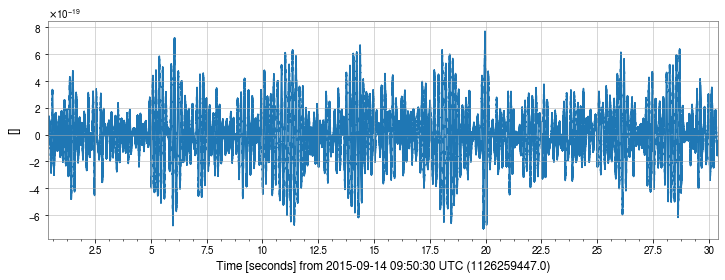

In [13]:
plot = data.plot()

This is the real LIGO data (one of two detectors) used to make the first direct detection of GWs. Do you spot the signal yet?

Let's add a title and y-axis labels to make it more clear what we're looking at. 

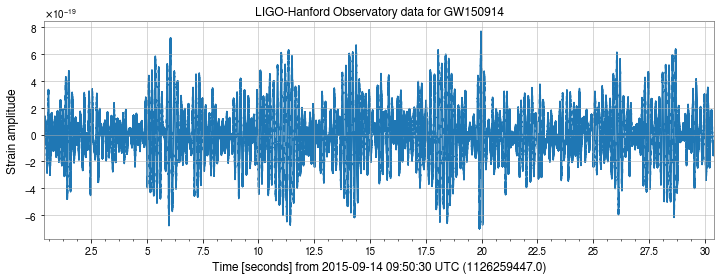

In [12]:
plot = data.plot(
    title='LIGO-Hanford Observatory data for GW150914',
    ylabel='Strain amplitude'
)

Nice.

---

## Make a spectral density plot

What does the data containing the signal look like in the frequency domain? 

We can then call the `.asd()` method to calculate the amplitude spectral density and tranform our `TimeSeries` into a `FrequencySeries`.

Syntax:
`asd(FFT_length_in_seconds, FFT_overlap_in_seconds, default_time_window='hann', default_FFT_method='welch')`

In [14]:
gw140914asd = data.asd(5, 2)
print(gw140914asd)

FrequencySeries([9.58283562e-21, 1.87029489e-20, 8.68833972e-21,
                 ..., 1.93937366e-25, 1.64772330e-25,
                 7.15539953e-26]
                unit: 1 / Hz(1/2),
                f0: 0.0 Hz,
                df: 0.2 Hz,
                epoch: 1126259447.399902,
                name: Strain,
                channel: None,
                frequencies: None)


Now we can make a plot of our `FrequencySeries` with the same `.plot()` method we used for a `TimeSeries`. 

(5, 2000)

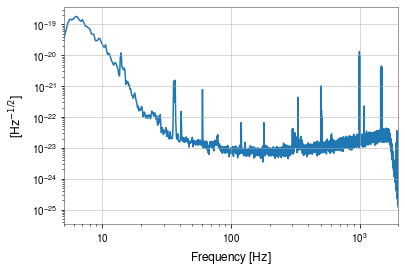

In [15]:
plot = gw140914asd.plot()
ax = plot.gca()
ax.set_xlim(5, 2000)


---
<span style="color:green">
    
## Exercise
    
How does this plot change with different FFT lengths and overlap? Try an FFT length of 15 seconds with 7 seconds of overlap and an FFT length of 2 with 1 second of overlap. What do you notice?
    
</span>    

---

## Filter design in the frequency domain


Now that we have a sense of what frequency content is dominating our noise, let's see if we can dig out the basic shape of our signal with a few simple filters. 

First, since we know our signal duration is short (on the order of miliseconds), let's zoom way in on the time series and see if we can spot it. 


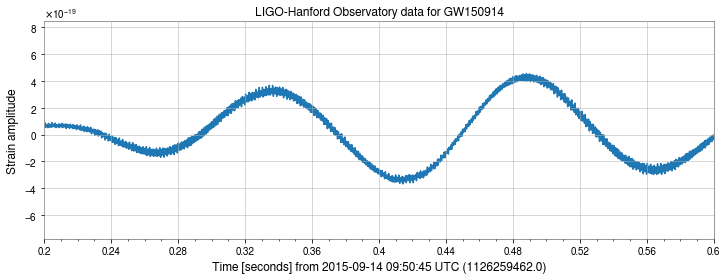

In [16]:
## Make a new plot, this time zoomed in around the time of GW150914
zoomplot = data.plot(
    title='LIGO-Hanford Observatory data for GW150914',
    ylabel='Strain amplitude'
)
ax = zoomplot.gca()
ax.set_xlim(GW150914gps-0.2, GW150914gps+0.2)
ax.set_ylabel='Strain amplitude'

Not yet... Let's get rid of some of that dominating low frequency noise and see if we can see our signal any better. 

### Apply a highpass filter



(1126259462.2, 1126259462.6000001)

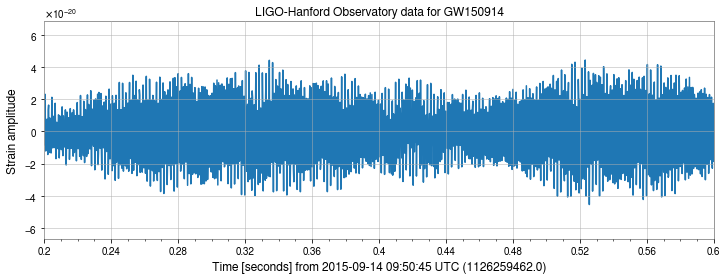

In [17]:
## apply a highpass filter with a corner frequency of 20 Hz 
gw140914hp = data.highpass(20)

## make a plot of the resulting time series
tsplot = gw140914hp.plot(
    title='LIGO-Hanford Observatory data for GW150914',
    ylabel='Strain amplitude'
)
ax = tsplot.gca()
ax.set_xlim(GW150914gps-0.2, GW150914gps+0.2)

Still no. What's left? What does our highpassed data look like in the frequency domain?

(5, 2000)

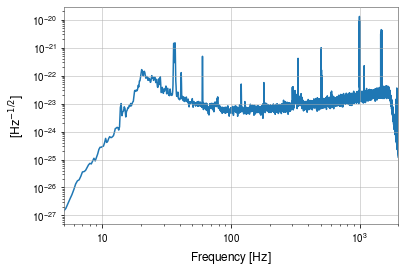

In [18]:
## make an ASD of the highpassed data (FFT length 5 seconds, overlap 5 seconds)
gw140914hpasd = gw140914hp.asd(5, 2)

## make a plot of that ASD! 
asdplot = gw140914hpasd.plot()
ax = asdplot.gca()
ax.set_xlim(5, 2000)

We've really supressed that low frequency noise! But there's still too much noise at other frequencies.  


### Apply a bandpass filter 

Because we've already identified our signal as a binary black hole system (two equal-ish mass black holes of roughly 30 solar masses each), we know our signal has frequency content (within our detector's sensitive range) between 50 and 250 Hz. 

Let's apply a bandpass filter to look for excess power in that critical frequency range. 

(-2e-21, 2e-21)

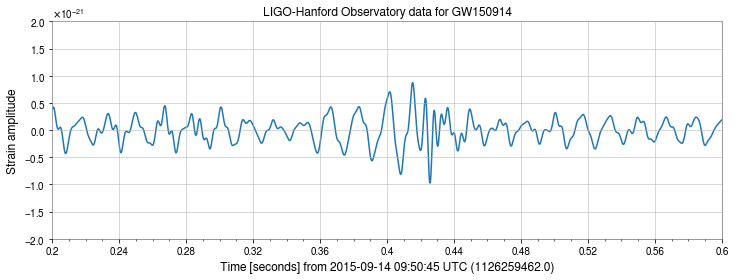

In [19]:
## apply a bandpass filter to the highpassed data with a corner frequencies of 50 and 250 Hz 
gw140914bp = gw140914hp.bandpass(50,250)

## make a plot of the resulting time series
tsplot = gw140914bp.plot(
    title='LIGO-Hanford Observatory data for GW150914',
    ylabel='Strain amplitude'
)
ax = tsplot.gca()
ax.set_xlim(GW150914gps-0.2, GW150914gps+0.2)
ax.set_ylim(-0.2e-20, 0.2e-20)

Starting to look promising, but check out that strong unrelated sinusoid. *What the heck is that?* 

To the frequency domain! (Read: let's make a spectrum and check it out.) 

(5, 2000)

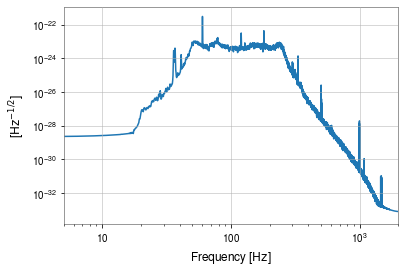

In [20]:
## make an ASD of the bandpassed data (FFT length 5 seconds, overlap 5 seconds)
gw140914bpasd = gw140914bp.asd(5, 2)

## make a plot of that ASD 
asdplot = gw140914bpasd.plot()
ax = asdplot.gca()
ax.set_xlim(5, 2000)

Wow, check out that strong line; this is the **60 Hz AC power line!**

Let's get rid of it with a notch filter.  

### Apply a notch filter 


(-1e-21, 1e-21)

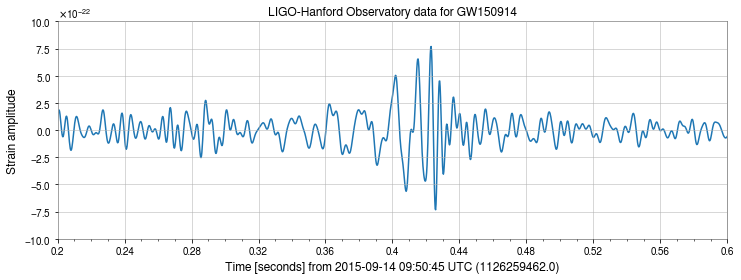

In [21]:
## apply a notch filter to the bandpassed data at 60 Hz 
gw140914n = gw140914bp.notch(60)

## make a plot of the resulting time series
tsplot = gw140914n.plot(
    title='LIGO-Hanford Observatory data for GW150914',
    ylabel='Strain amplitude'
)
ax = tsplot.gca()
ax.set_xlim(GW150914gps-0.2, GW150914gps+0.2)
ax.set_ylim(-0.1e-20, 0.1e-20)

There it is! Nice work! We can put that on a T-shirt. 

----

<span style="color:green">
    
## Exercise
Repeat this for LIGO-Livingston detector data around the time of GW150914. Design your own set of simple filters for LIGO-Livingston, and plot the filtered LIGO-Livingston and LIGO-Hanford time series data overlaid. Can you estimate the difference in signal arrival times between detectors? 
    
</span>    

<span style="color:gray">Note: the LIGO-Virgo analyses always use whitening; not the procedure above.</span>

----

## Apply and characterize a whitening filter

It's much easier to spot excess power in the data if we can weight it proportionally by the consistent frequency contributions from the noise its embedded in. (Whitening is a critical step for matched filtering and gravitational wave search algorithms that look for coherent excess power across a gravitational wave detector network.)

We can use GWpy to `whiten` our data for the time of GW150914 with an FFT length of 5 seconds and an overlap of 2 seconds.


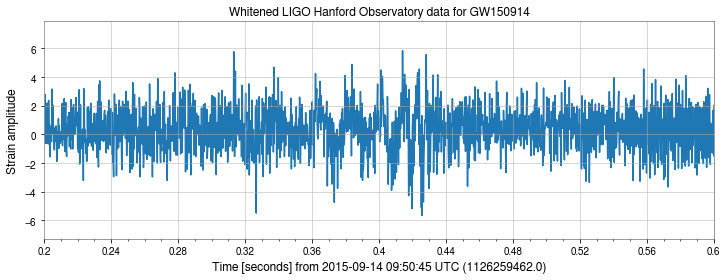

In [22]:
whitened_gw150914 = data.whiten(5,2)
plot = whitened_gw150914.plot(
    title='Whitened LIGO Hanford Observatory data for GW150914',
    ylabel='Strain amplitude',
    xlim=(GW150914gps-0.2, GW150914gps+0.2)
)

Hmm, that looks like it still has some high frequency noise left. 

What does the whitened data look like in the frequency domain?

(5, 2000)

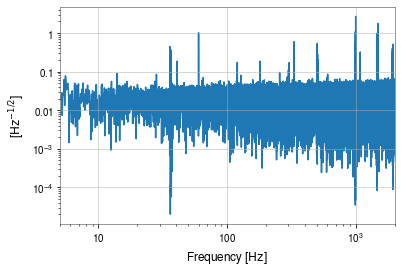

In [23]:
whitened_gw150914_asd = whitened_gw150914.asd()
plot = whitened_gw150914_asd.plot()
ax = plot.gca()
ax.set_xlim(5, 2000)

Not perfectly "white" yet. How would you improve it? 

---

<span style="color:green">
    
## Exercise
    
Compare the ASD of your whitened LIGO-Hanford data to the ASD of your data with the simple filter set (highpass, bandpass, notch) for LIGO-Hanford applied. Which frequencies still stand out in which? 

</span>

---

## Visualize LIGO data with spectrograms

A great way to visualize how the frequency content of our data is changing over time is with whitened or "normalized" spectrograms. 

Let's try it for GW150914. 

We can apply the `spectrogram2()` method in GWpy to our whitened data, and set some other formatting variables to make the plot look nice: 

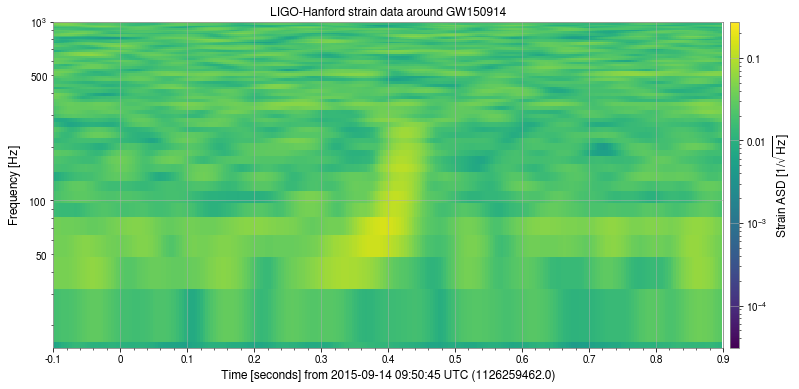

In [24]:
specgram = whitened_gw150914.spectrogram2(fftlength=1/16., overlap=15/256.) ** (1/2.)
plot = specgram.plot(norm='log', cmap='viridis', yscale='log')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_xlim(GW150914gps-0.5, GW150914gps+0.5)
ax.set_ylim(15,1000)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')

There is something there! It looks like it's sweeping up in frequency over time, but it's still hard to make out the details. 

---- 

### The Q transform

To zoom in even further, we can employ a [muli-resolution technique](https://arxiv.org/abs/gr-qc/0412119) called the [Q transform](https://gwpy.github.io/docs/latest/api/gwpy.timeseries.TimeSeries.html?highlight=q_transform#gwpy.timeseries.TimeSeries.q_transform). 

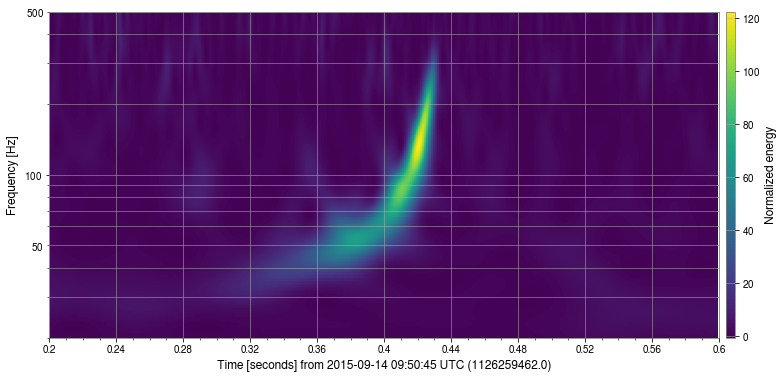

In [25]:
qspecgram = data.q_transform(outseg=(GW150914gps-0.2, GW150914gps+0.2))
plot = qspecgram.plot()
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')

Beautiful. Nice work! 

---

<span style="color:green">
    
## Challenge

Generate a frequency vs. time plot of LIGO data around the binary neutron star event (GW170817) where you can clearly see the signal track. (Hints: consider using LIGO-Livingston data, a Q transform, and note that binary neutron star signals last for 10s of seconds!) 
</span>

---